<a href="https://colab.research.google.com/github/VladimirBlinov/ColabNotebooks/blob/main/Trading_NET_v3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Загрузка данных**

In [1]:
!pip install finam-export

In [2]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
import numpy as np #Numpy
import os
import random
import time
from IPython.display import clear_output
from tqdm import tqdm

from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D,MaxPooling1D, Activation, Reshape #Стандартные слои
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов
import keras.backend as K
from tensorflow.keras.callbacks import LambdaCallback,ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from keras.models import load_model
from tensorflow.keras import regularizers
from keras.utils import to_categorical
from tensorflow.keras.metrics import AUC, MAE
from keras.utils import plot_model
from keras.models import load_model

from sklearn import utils
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix,roc_auc_score, roc_curve, precision_recall_fscore_support

from scipy import stats

import logging

from finam import Exporter, Market, LookupComparator, Timeframe
from finam.utils import click_validate_enum


# Рисовать графики сразу же
%matplotlib inline

pd.options.mode.chained_assignment = None

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Получаем входные данные

In [60]:
# Get data of stock
file_name = 'Trading_NET_v3_1'
exporter = Exporter()
ticker = exporter.lookup(market=Market.USA, name='Microsoft',
                          name_comparator=LookupComparator.CONTAINS)
assert len(ticker) == 1
data_initial = exporter.download(ticker.index[0], market=Market.USA, timeframe=Timeframe.HOURLY)
data = data_initial.copy()
data = data.iloc[:,2:]
data.reset_index(inplace=True, drop=True)
data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,29.910,30.010,29.8499,29.8500,7409675
1,29.850,30.050,29.8300,29.9500,10113135
2,29.950,30.130,29.9300,30.0850,6752946
3,30.080,30.250,30.0500,30.1799,5903632
4,30.180,30.210,30.1000,30.1600,6269579
...,...,...,...,...,...
25163,259.540,259.670,259.0100,259.4700,112385
25164,259.470,260.615,259.4100,260.1900,148315
25165,260.170,260.470,259.8300,259.9200,94429
25166,259.915,260.800,259.8650,260.5800,93445


# Подготовка данных

In [61]:
xlen = 24  # Сколько свечек берем в каждый кадр
forward_lag = 5  # Насколько шагов вперед делаем цель
flat = 0.005  # Предел боковика
col = data.columns.tolist()  # Получаем список колонок
price_columns = col[:-1]  # Создаем список колонок с ценами
volume_column = col[-1]  # Колонка с объемом
data


,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,29.910,30.010,29.8499,29.8500,7409675
1,29.850,30.050,29.8300,29.9500,10113135
2,29.950,30.130,29.9300,30.0850,6752946
3,30.080,30.250,30.0500,30.1799,5903632
4,30.180,30.210,30.1000,30.1600,6269579
...,...,...,...,...,...
25163,259.540,259.670,259.0100,259.4700,112385
25164,259.470,260.615,259.4100,260.1900,148315
25165,260.170,260.470,259.8300,259.9200,94429
25166,259.915,260.800,259.8650,260.5800,93445


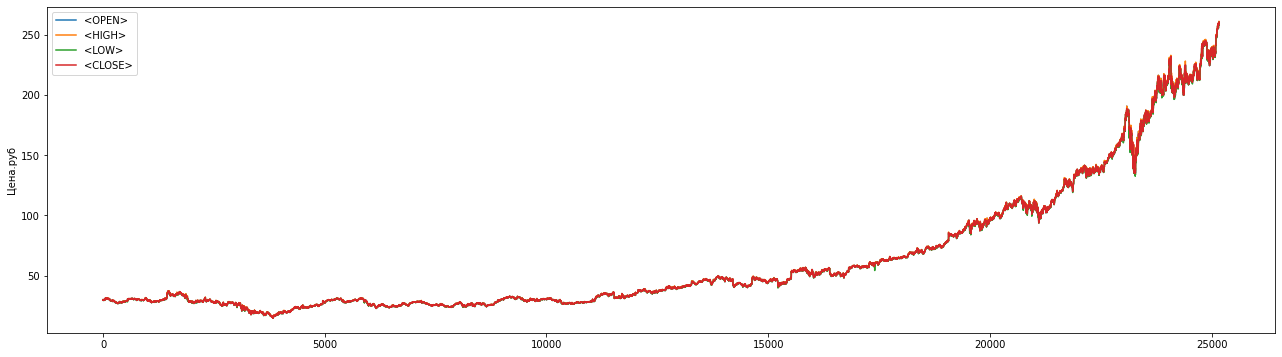

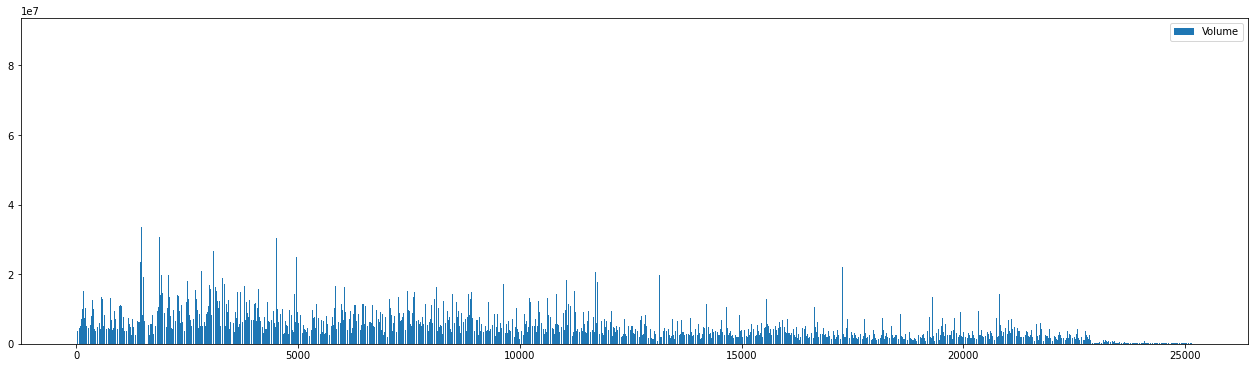

In [6]:
# Draw the data in channels
plt.figure(figsize=(22,6))
for i in range(4):
  plt.plot(data.iloc[:,i], 
          label=col[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volume
plt.figure(figsize=(22,6))
plt.bar(x=data.index, height=data.iloc[:,4], label="Volume")
plt.legend()
plt.show()

In [124]:
# Split dataset to train and test. Test 20%
test_len = data.shape[0] - int(data.shape[0]*0.2)
data_test = data.iloc[test_len:]
data_train_initial = data.iloc[:test_len]
data_train = data_train_initial.copy(deep=True)

print(data.shape[0])
print(test_len)
print(data_train.shape[0])
print(data_test.shape[0])


25168
20135
20135
5033


In [63]:
# Split dataset to train and test. Test 20%
test_len = data.shape[0] - int(data.shape[0]*0.2)
data_test = data.iloc[test_len:]
data_train_initial = data.iloc[:test_len]
data_train = data_train_initial.copy(deep=True)

#определяем цель для использования в нейронке с категоризации
def target(df):
  pd.options.mode.chained_assignment = None
  df['Y'] = 0
  for i in range(1,forward_lag+1):
    column_name_up = 'Y%d'%(i)
    df[column_name_up] = df['<HIGH>'].shift(-i)
    df.loc[((df[column_name_up] - df['<CLOSE>']) / df['<CLOSE>']) >= (0+flat), column_name_up] = 1
    df.loc[df[column_name_up] != 1, column_name_up] = 0
    df.loc[df[column_name_up] != 0, 'Y'] = 1
    del df[column_name_up]
  
  df['Y'] = df['Y'].shift(1)  # It is necessary to apply later keras.timeseries generator
  
  df.dropna(axis=0, how = 'any',inplace=True)
  return df

data_train = target(data_train)
data_train

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,Y
1,29.850,30.05,29.8300,29.9500,10113135,1.0
2,29.950,30.13,29.9300,30.0850,6752946,1.0
3,30.080,30.25,30.0500,30.1799,5903632,1.0
4,30.180,30.21,30.1000,30.1600,6269579,0.0
5,30.160,30.20,29.4000,29.4900,11081517,0.0
...,...,...,...,...,...,...
20130,102.230,102.27,101.9000,102.0600,1187739,0.0
20131,102.070,102.47,102.0661,102.4250,1130180,1.0
20132,102.435,102.59,102.2700,102.5700,3622904,0.0
20133,102.650,102.69,102.0500,102.1500,2121308,0.0


In [65]:
data_train[data_train['Y'] ==1]['Y'].count()

11960

In [66]:
def data_preprocessing(data, train=True):
  '''
  Function for data preprocessing. Calculates pct_change, makes scalling separatelly for price and volumes, saves scalers. 
  Separates dataset xTrain, xTest, yTrain, yTest, yTrain01, yTest01
  return: ndarrays and scaler
  '''
  # Pct_change for price columns
  for c in price_columns:
    data[c]=data[c].pct_change()

  
  data[volume_column] = data[volume_column] + 1e-5  # Add very small figure to exclude devide by 0
  data[volume_column] = data[volume_column].pct_change()
  data.dropna(axis=0, how='any', inplace=True)

  if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/Dipl/scalers/"):
    os.makedirs("/content/drive/MyDrive/Colab Notebooks/Dipl/scalers/")

  price_scaler_filename="/content/drive/MyDrive/Colab Notebooks/Dipl/scalers/price_scaler.save"
  volume_scaler_filename="/content/drive/MyDrive/Colab Notebooks/Dipl/scalers/volume_scaler.save"

  if train:
    data = np.array(data)
    # Split dataset to train and test
    val_len = int(data.shape[0]*0.15)
    train_len = data.shape[0] - val_len
    xTrain, xTest = data[:train_len,:-2], data[train_len + xlen:,:-2]
    print(xTrain.shape)
    yTrain01, yTest01 = np.reshape(data[:train_len,-1], (-1,1)), np.reshape(data[train_len + xlen:,-1], (-1,1))
    
    # Make scale
    price_scaler = StandardScaler()
    price_scaler.fit(np.reshape(xTrain[:,3], (-1,1)))

    xTrain[:,:4] = price_scaler.transform(xTrain[:,:4])
    xTest[:,:4] = price_scaler.transform(xTest[:,:4])
    
    yTrain, yTest = np.reshape(xTrain[:,3], (-1,1)), np.reshape(xTest[:,3], (-1,1))
    joblib.dump(price_scaler, price_scaler_filename)
    
    volume_scaler = StandardScaler()
    '''
    volume_scaler.fit(np.reshape(xTrain[:,4], (-1,1)))
   
    xTrain[:,4] = np.reshape(volume_scaler.transform(np.reshape(xTrain[:,4], (-1,1))), (1, -1))
    xTest[:,4] = np.reshape(volume_scaler.transform(np.reshape(xTest[:,4], (-1,1))), (1,-1))
    
    joblib.dump(volume_scaler, volume_scaler_filename)
    '''

    return xTrain, xTest, yTrain, yTest, yTrain01, yTest01, price_scaler, volume_scaler
    
  else:
    data = np.array(data)
    xTest = data[-xlen:,:]
    price_scaler = joblib.load(price_scaler_filename) 
    volume_scaler = joblib.load(volume_scaler_filename)

    xTest[:,:4] = price_scaler.transform(xTest[:,:4])
    xTest[:,4] = np.reshape(volume_scaler.transform(np.reshape(xTest[:,4], (-1,1))), (1,-1))
    
    xTest = np.expand_dims(xTest, axis=0)
    return xTest, price_scaler
  


In [67]:
xTrain, xTest, yTrain, yTest, yTrain01, yTest01, price_scaler, volume_scaler = data_preprocessing(data_train, train = True)

(17114, 4)


In [68]:
print(xTrain)
print(yTrain01)

[[ 0.49487786  0.39142622  0.49521567  0.66895241]
 [ 0.64384429  0.59002808  0.59403072  0.46544686]
 [ 0.49102532 -0.20783974  0.24127883 -0.10813591]
 ...
 [-0.8217853  -0.54497793 -0.45736385 -0.19083887]
 [-0.19350381  0.18700215  0.30849521  0.59800732]
 [ 0.63348289 -0.03523716 -0.1673635  -0.77120582]]
[[1.]
 [1.]
 [0.]
 ...
 [1.]
 [1.]
 [0.]]


In [69]:
# To check the right scaling/unscaling
print(data.head())
print('with pct change')
print(data_train.head())
print('xtrain')
print(xTrain[:5,:4])
print('inv trans xtrain')
print(price_scaler.inverse_transform(xTrain[:5,:4]))
print('inv trans ytrain')
print(price_scaler.inverse_transform(yTrain[:5]))

   <OPEN>  <HIGH>    <LOW>  <CLOSE>     <VOL>
0   29.91   30.01  29.8499  29.8500   7409675
1   29.85   30.05  29.8300  29.9500  10113135
2   29.95   30.13  29.9300  30.0850   6752946
3   30.08   30.25  30.0500  30.1799   5903632
4   30.18   30.21  30.1000  30.1600   6269579
with pct change
     <OPEN>    <HIGH>     <LOW>   <CLOSE>     <VOL>    Y
2  0.003350  0.002662  0.003352  0.004508 -0.332260  1.0
3  0.004341  0.003983  0.004009  0.003154 -0.125769  1.0
4  0.003324 -0.001322  0.001664 -0.000659  0.061987  0.0
5 -0.000663 -0.000331 -0.023256 -0.022215  0.767506  0.0
6 -0.022215 -0.010596  0.002721  0.012886 -0.061990  1.0
xtrain
[[ 0.49487786  0.39142622  0.49521567  0.66895241]
 [ 0.64384429  0.59002808  0.59403072  0.46544686]
 [ 0.49102532 -0.20783974  0.24127883 -0.10813591]
 [-0.10863392 -0.05875088 -3.50658632 -3.35002842]
 [-3.35002842 -1.60258419  0.40027845  1.92901563]]
inv trans xtrain
[[ 0.00335008  0.00266223  0.00335233  0.00450751]
 [ 0.00434057  0.00398274  0.004009

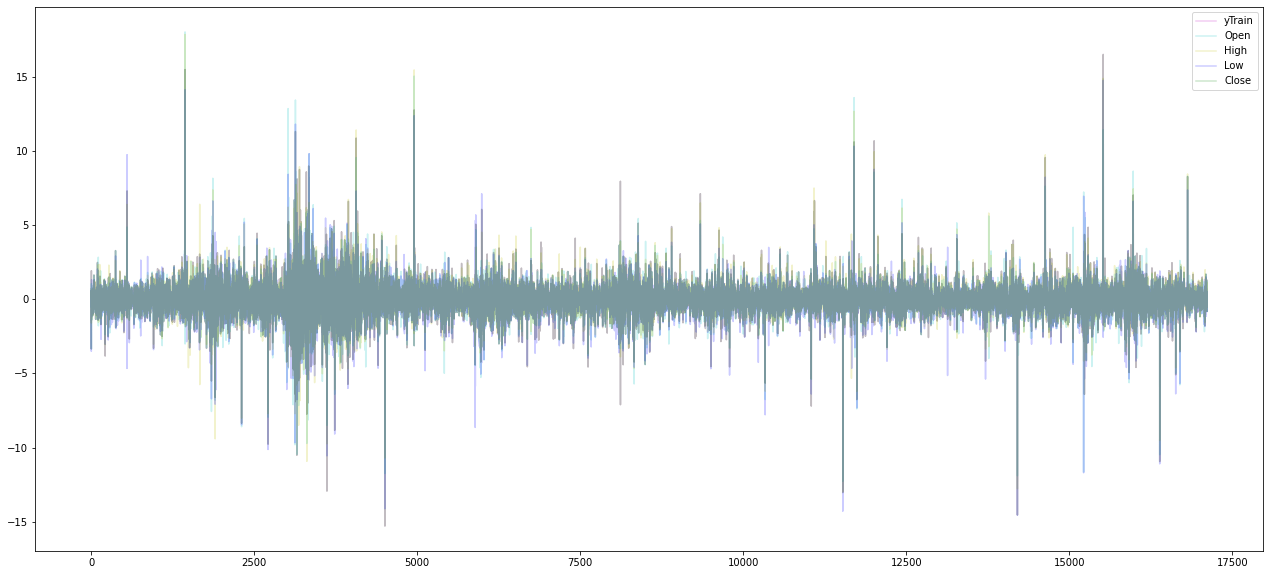

In [112]:
# Draw scalled dataset to check
plt.figure(figsize=(22,10))
plt.plot(yTrain, 'm', label='yTrain', alpha=0.2)
plt.plot(xTrain[:,0], 'c', label='Open', alpha=0.2)
plt.plot(xTrain[:,1], 'y', label='High', alpha=0.2)
plt.plot(xTrain[:,2], 'b', label='Low', alpha=0.2)
plt.plot(xTrain[:,3], 'g', label='Close', alpha=0.2)
#plt.plot(xTrain[:,4], 'r', label='Volume', alpha=0.2)
plt.legend()
plt.show()

In [70]:
# Make time series
train_datagen = TimeseriesGenerator(xTrain, yTrain01, xlen, batch_size=20, shuffle=True)
test_datagen = TimeseriesGenerator(xTest, yTest01, xlen, batch_size=20, shuffle=True)

In [43]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  '''
  Предсказываем ответ сети по проверочной выборке
  Возвращаем исходны масштаб данных, до нормализации
  '''
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    if showGraf: #Если нужно показать график
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

  if showGraf: #Если нужно показать график
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if returnData: #Если нужно вернуть массивы автокорреляции
    return corr, own_corr

In [95]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
datagen = TimeseriesGenerator(xTest, yTest01,
                               length=xlen, sampling_rate=1,
                               batch_size=len(xTest), shuffle=True) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in datagen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal[0])
yVal = np.array(yVal[0])

print(yVal.shape)
print(yVal[yVal > 0.5].shape)

(2995, 1)
(1576,)


In [51]:
#callback для первой модели

reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                              patience=40, min_lr=0.000001, verbose=1, mode="max" )
early_stop = EarlyStopping(
    monitor='val_auc', min_delta=0, patience=70, verbose=1,
    mode='max', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/Dipl/model.h5', monitor='val_auc', verbose = 1,
                             save_best_only = True, mode='max')

def on_epoch_end_acc(epoch, logs):
  clear_output(wait=True)
  print('current_val_auc',logs['val_auc'])
  print('current bot_epoch:', it + 1, 'of', bot_epohs)
  print('current bot:', bot_number + 1, 'of', n)
  print('last_bot_accuracy:', val )
  print('last_bot_trade_profit:', trade_profit_list)
  print('last_bot_profit_ratio:', profit_ratio_list)
  print('last_bot_trades:', total_trades_list)

clear = LambdaCallback(on_epoch_end=on_epoch_end_acc)

Epoch 1/1000
855/855 [==============================] - 3s 3ms/step - loss: 0.7053 - auc: 0.5187 - val_loss: 0.7124 - val_auc: 0.4840
Epoch 2/1000
855/855 [==============================] - 3s 3ms/step - loss: 0.6856 - auc: 0.5231 - val_loss: 0.7109 - val_auc: 0.5355
Epoch 3/1000
855/855 [==============================] - 3s 3ms/step - loss: 0.6822 - auc: 0.5164 - val_loss: 0.7147 - val_auc: 0.5056
Epoch 4/1000
855/855 [==============================] - 3s 3ms/step - loss: 0.6862 - auc: 0.5045 - val_loss: 0.7232 - val_auc: 0.5170
Epoch 5/1000
855/855 [==============================] - 3s 3ms/step - loss: 0.6875 - auc: 0.5093 - val_loss: 0.7199 - val_auc: 0.5234
Epoch 6/1000
855/855 [==============================] - 3s 3ms/step - loss: 0.6828 - auc: 0.5175 - val_loss: 0.6981 - val_auc: 0.5485
Epoch 7/1000
855/855 [==============================] - 3s 3ms/step - loss: 0.6847 - auc: 0.5089 - val_loss: 0.7052 - val_auc: 0.5349
Epoch 8/1000
855/855 [==============================] - 3s 3ms

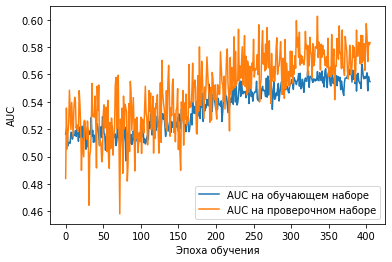

In [96]:
def create_model():
  inputs = Input(shape=(train_datagen[0][0][0].shape))
  dense = Dense(24, activation='linear')(inputs)
  dense = Dropout(0.2)(dense)
  dense = Flatten()(dense)
  
  #conv = Conv1D(64, 5, activation='relu', padding='same')(inputs)
  #conv = Conv1D(64, 5, activation='relu', padding='same')(conv)
  #conv = MaxPooling1D(2)(conv)
  #conv = Conv1D(128, 5, activation='relu', padding='same')(conv)
  #conv = Conv1D(128, 5, activation='relu', padding='same')(conv)
  #conv = MaxPooling1D(2)(conv)
  #conv = Flatten()(conv)
  #final = concatenate([dense, conv])
  final = Dense(1, activation='sigmoid')(dense)

  model = Model(inputs, final)
  return model

model = create_model()
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-2),  metrics=[AUC(name="auc")])

#Запускаем обучение
history = model.fit(train_datagen, 
                    epochs=1000,
                    verbose=1, 
                    validation_data=test_datagen,
                    callbacks=[reduce_lr, early_stop],
                    )

plt.plot(history.history['auc'], 
         label='AUC на обучающем наборе')
plt.plot(history.history['val_auc'], 
         label='AUC на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('AUC')
plt.legend()
plt.show()


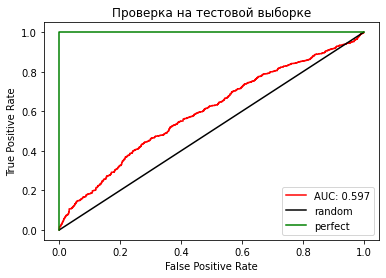

[1 0 0 ... 1 1 0]
[1 0 0 ... 0 0 1]
tn: 729 fp: 690 fn: 602 tp: 974
              precision    recall  f1-score   support

           0       0.55      0.51      0.53      1419
           1       0.59      0.62      0.60      1576

    accuracy                           0.57      2995
   macro avg       0.57      0.57      0.57      2995
weighted avg       0.57      0.57      0.57      2995


Positive 1703 Negative 1292 Accuracy 56.86%



In [97]:
pred = model.predict(xVal)

roc_auc = roc_auc_score(yVal, pred)
fpr, tpr, thresholds = roc_curve(yVal, pred)
print()
plt.plot(fpr, tpr,'r-',label = 'AUC: %.3f'%roc_auc)
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect',)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Проверка на тестовой выборке')
plt.show()

pred = np.array([(1 if i>0.6 else 0) for i in pred])
real = np.array([(1 if i>0.5 else 0) for i in yVal])
print(pred)
print(real)

tn, fp, fn, tp = confusion_matrix(real, pred).ravel()
print('tn:', tn, 'fp:', fp, 'fn:', fn, 'tp:', tp)

print(classification_report(real, pred))

cnt_pos=0
cnt_neg=0
for i in range(real.shape[0]):
  #print('Predict', pred[i], 'Real',real[i])
  if pred[i] == real[i]:
    cnt_pos +=1
  else:
    cnt_neg+=1

print()
print('Positive', cnt_pos, 'Negative',cnt_neg, 'Accuracy {:.2%}'.format(cnt_pos/(cnt_pos+cnt_neg)))
print()

In [138]:
test_model(model)

100%|██████████| 5033/5033 [03:41<00:00, 22.69it/s]

total_trades 1187
positive_trades_ratio 0.5299073294018534 positive_trades 629
negative_trades_ratio 0.4700926705981466 negative_trades 558
draw_down -13.569999999999993
max_profit 11.829999999999984
profit_ratio 1.06
trade_accuracy 94477.72


(94477.72, 1.06, 1187)

# Генерируем сеть с помощью ГА

In [137]:
def predTimeseriesGenerator(xTest, step_in_the_past):
  '''
  Функция для преобразования размера входного массива в требуемый для нейросети.
  '''
  xTest = xTest[-step_in_the_past:,:,:4] #формируем х длинной step_in_the_past 
  xTest = np.array(xTest) #Преобразуем в numpy
  
  return xTest

In [135]:
#Функция прогноза
def get_prediction (model, xPred, yScaler, classification=False):
  '''
  Функция для прогноза данных модели регрессии.
  Если classification=True, возвращает номер класса
  По умолчанию возвращает предсказанное значение
  model - модель
  xPred - входной массив данных
  yScaler - скалер для y
  classification - флаг классификации
  '''
  prediction = model.predict(xPred)  # Get prediction by model
  if classification:  # If classification
    return prediction  # Return probability of 1
  else:
    prediction = yScaler.inverse_transform(prediction)
    return prediction  # Return predicted figure

In [136]:
def trade(data_enter, model, step_in_the_past):
  '''
  Функция подготовки входных данных, прогноза цены и определения торгового решения
  '''
  data = data_enter.copy(deep=True)  # Копируем входной датасет, чтобы в нем не было изменений 
  xTest, yScaler = data_preprocessing(data, train=False)  # Делаем предобработку данных в массиве функцией data_preprocessing
  xTest = predTimeseriesGenerator(xTest, step_in_the_past) #формируем вектор со взглядом назад для подачи в сеть
  yPred = get_prediction(model, xTest, yScaler, classification=True) #делаем прогноз следующей цены закрытия

  yPred = yPred[0][0]
  action = np.random.choice(a=[1,0], size=1, p=[yPred, 1-yPred])

  return action

In [139]:
def test_model(model):
  '''
  Function to test model by trading on Test dataset
  return: trade_accuracy, profit_ratio
  '''
  initial_money = 100000 # Стартовый капитал
  money = initial_money 
  shares = 0 # Стартовое количество акций
  dataset = data_train_initial  # Get initial test dataset
  money_history = [money] # Статистика капитала

  last_prediction=[0]
  pos=0  # Current position
  enter_price = 0  
  exit_price = 0
  profit_history=[]
  negative_trades = []
  positive_trades = []
  ticker = 3  # Берем цену из колонки "Close"

  # Проходим по всему тестовому датасету
  for i in tqdm(range(1, data_test.shape[0]+1), position=0):
    df = dataset.append(data_test[:i]).reset_index(drop=True) # Считываем очередное значение из тестового датасета и добавляем в основной датасет
    action = trade(df, model, xlen) # Получаем действие, которое будем совершать
    
    # Если это последнее значение тестовой выборки, не торгуем
    if i == data_test.shape[0]:
      action = 0  
      if shares != 0:
        money += shares * df.iloc[-1][ticker] # Продаем все акции и увеличиваем капитал на заработанные деньги
        shares = 0 # Количество акцией сбрасываем в 0

    # Если должны покупать и есть деньги хотя бы на одну акцию
    if action==1 and money > df.iloc[-1][ticker] and shares == 0:
      shares += money // df.iloc[-1][ticker] # Покупаем на все имеющиеся деньги акции (покупаем целое количество (не обязательно))
      money = round(money % df.iloc[-1][ticker], 2) # Считаем сколько осталось денег после покупки акций
      enter_price = df.iloc[-1][ticker]

    # Если должны продавать и есть акции
    elif action==0 and shares != 0:
      money += round((shares * df.iloc[-1][ticker]), 2) # Продаем все акции и увеличиваем капитал на заработанные деньги
      shares = 0 # Количество акцией сбрасываем в 0
      money_history.append(round(money,2)) # Записываем в статистику капитала текущее значение имеющихся денег
      trade_accuracy = round((money_history[-1] - initial_money), 2)
      exit_price = df.iloc[-1][ticker]
      profit_history.append(exit_price - enter_price)

  positive_trades = [i for i in profit_history if i>0]
  negative_trades = [i for i in profit_history if i<=0]
  total_trades = len(profit_history)
  if total_trades != 0:
    positive_trades_ratio = len(positive_trades) / total_trades
    negative_trades_ratio = len(negative_trades) / total_trades
    if len(positive_trades) == 0:
      max_profit = 0
      mean_profit = 0
    else:
      max_profit = max(positive_trades)
      mean_profit = sum(positive_trades) / len(positive_trades)
    if len(negative_trades) == 0:
      draw_down = 0
      mean_loss = 0
      profit_ratio = 1
    else:
      draw_down = min(negative_trades)
      mean_loss = abs(sum(negative_trades)) / len(negative_trades)
      profit_ratio = round(mean_profit / mean_loss, 2)
    
    print('total_trades', total_trades)
    print('positive_trades_ratio', positive_trades_ratio, 'positive_trades', len(positive_trades))
    print('negative_trades_ratio', negative_trades_ratio, 'negative_trades', len(negative_trades))
    print('draw_down', draw_down)
    print('max_profit', max_profit)
    print('profit_ratio', profit_ratio)
  else:
    draw_down = 0
    profit_ratio = 0
    print('total_trades', 0)
    
  trade_accuracy = round((money_history[-1] - initial_money + draw_down), 2)
  print('total_return: ', round((money_history[-1] - initial_money), 2))
  print('trade_accuracy', trade_accuracy)
  return trade_accuracy, profit_ratio, total_trades  # Возвращаем финальный прирост капитала

current_val_auc 0.5684018731117249
current bot_epoch: 5 of 5
current bot: 10 of 10
last_bot_accuracy: [72113.81, 170066.93, 90593.03, 168944.62, 125901.87, 84309.84, 119430.51, 82260.55, 158483.6, 63331.16]
last_bot_trade_profit: [77541.73, 170066.93, 95361.08, 152202.36, 119906.54, 83475.09, 127053.73, 78343.38, 152388.08, 65969.96]
last_bot_profit_ratio: [0.93, 1.0, 0.95, 1.11, 1.05, 1.01, 0.94, 1.05, 1.04, 0.96]
last_bot_trades: [414, 1113, 1182, 1029, 1208, 1116, 915, 1120, 979, 963]
Epoch 00072: early stopping
Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           [(None, 24, 4)]      0                                            
__________________________________________________________________________________________________
batch_normalization_67 (BatchNo (None, 24, 4)        16          

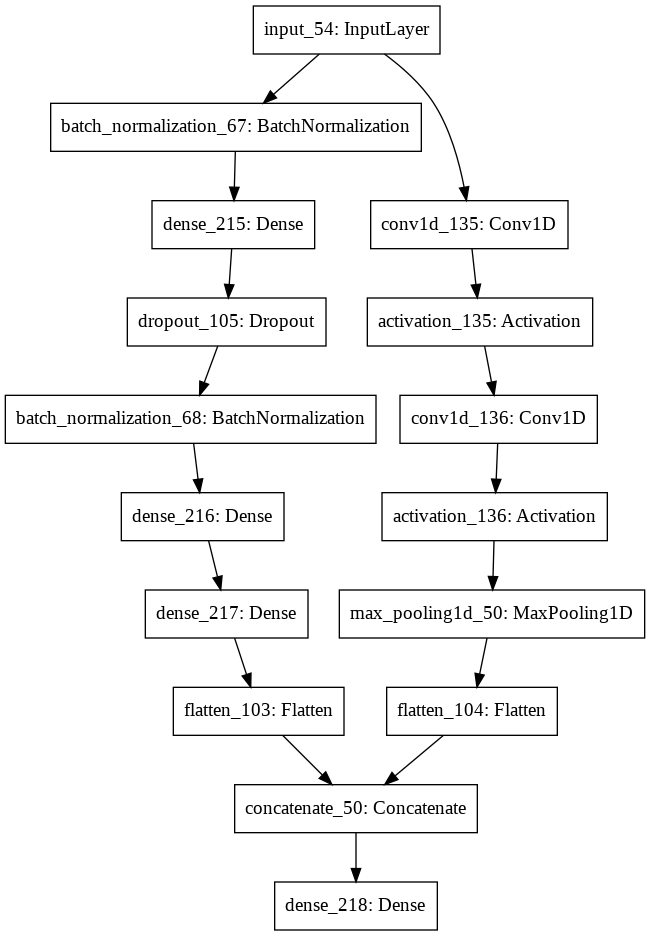

In [140]:
#Создаём нейронку
def create_model_reg(net):
  '''
  Функция создает модель по значениям, полученным из бота
  return: model
  '''
  normalization_on_start = net[0]  # Нормализация перед первым слоем
  dense_on_start_size = 2 ** net[1]    # Размер слоя на старте
  dense_on_start_activation = net[2]    # Активация слоя тна старте
  dense_dropout_on_start = net[3]   # Дропаут на старте
  dropout_on_start_size = net[4]  # Коэффициент Дропаут на старте

  dense_layer = []  # Список для создания Dense слоев
  dense_layer_norm = []  # Список для создания BatchNormalization слоев
  dense_layer_size = []  # Список размеров Dense слоев
  dense_layer_activation = []  # Список активаций Dense слоев
  dense_layer_dropout = []  # Список для создания Dropout слоев
  dense_layer_dropout_size = []  # Список размеров Dropout слоев
  for i in range(max_dense):
    dense_layer.append(net[5 + 6*i])  # Добавляем вкл/выкл для i-го Dense слоя из бота
    dense_layer_norm.append(net[6 + 6*i])  # Добавляем вкл/выкл BatchNormalization для i-го слоя из бота
    dense_layer_size.append(2 ** net[7 + 6*i])  # Добавляем кол-во нейронов для i-го слоя из бота
    dense_layer_activation.append(net[8 + 6*i]) # Активация 
    dense_layer_dropout.append(net[9 + 6*i])  # Dropout
    dense_layer_dropout_size.append(net[10 + 6*i])  # Размер Dropout

  conv_layer = []  # Список для создания слоев
  conv_size = []  # Список размеров слоев
  conv_kernel = []  # Список размеров ядра свертки
  conv_activation = []  # Список активация 
  max_pooling = []  # MaxPooling
  max_pooling_size = []  # MaxPolling size
  for i in range(max_conv):
    conv_layer.append(net[5 + max_dense*6 + 6*i])  # Создаем слой
    conv_size.append(2 ** net[6 + max_dense*6 + 6*i])  # Кол-во нейронов i-го слоя из бота
    conv_kernel.append(net[7 + max_dense*6 + 6*i])  # Размер ядра i-го слоя из бота
    conv_activation.append(net[8 + max_dense*6 + 6*i]) # Активация i-го слоя из бота
    max_pooling.append(net[9 + max_dense*6 + 6*i])  # MaxPolling i-го слоя из бота
    max_pooling_size.append(net[10 + max_dense*6 + 6*i])  # Maxpooling size i-го слоя из бота
  
  lstm_layer = []
  lstm_size = []
  lstm_activation = []
  lstm_return_sequences = []
  for i in range(max_lstm):
    lstm_layer.append(net[5 + max_dense*6 + max_conv*6 + 4*i])
    lstm_size.append(net[6 + max_dense*6 + max_conv*6 + 4*i])
    lstm_activation.append(net[7 + max_dense*6 + max_conv*6 + 4*i])
    lstm_return_sequences.append(net[8 + max_dense*6 + max_conv*6 + 4*i])

  activation_list = ['linear','relu','tanh','softmax','sigmoid']  # Список активаций
  list_to_concat = []  # Список слоев для склейки перед Flatten()

  inputs = Input(shape=(train_datagen[0][0][0].shape))  # Входной слой
  if normalization_on_start:  # Если делаем нормализацию
    dense = BatchNormalization()(inputs) 
    dense = Dense(dense_on_start_size, activation=activation_list[dense_on_start_activation])(dense)
  else:
    dense = Dense(dense_on_start_size, activation=activation_list[dense_on_start_activation])(inputs)

  if dense_dropout_on_start: # Если делаем Dropout
    dense = Dropout(dropout_on_start_size)(dense)

  for i in range(max_dense): # Создаем Dense слои
    if dense_layer[i]:
      if dense_layer_norm[i]:
        dense = BatchNormalization()(dense)
        dense = Dense(dense_layer_size[i], activation=activation_list[dense_layer_activation[i]])(dense)

      else:
        dense = Dense(dense_layer_size[i],activation = activation_list[dense_layer_activation[i]])(dense)
        
      if dense_layer_dropout[i]:
        dense = Dropout(dense_layer_dropout_size[i])(dense)
  
  list_to_concat.append(dense) # Добавляем ветку на соединение

  conv_count = 0
  for i in range(max_conv):  # Создаем Conv слои
    if conv_layer[i]:
      if conv_count == 0:  # Если первый слой, то соединяем с inputs
        conv = Conv1D(conv_size[i], conv_kernel[i], padding = 'same')(inputs)
      else:
        conv = Conv1D(conv_size[i], conv_kernel[i], padding = 'same')(conv)
      conv = Activation(activation_list[conv_activation[i]])(conv)

      if max_pooling[i]:  # Если делаем MaxPooling
        conv = MaxPooling1D(max_pooling_size[i])(conv)
      conv_count +=1
  if conv_count != 0:
    list_to_concat.append(conv)  # Добавляем ветку на соединение

  
  lstm_count = 0
  for i in range(max_lstm):
    if lstm_layer[i]:
      if lstm_count == 0:
        lstm = LSTM(lstm_size[i], activation=activation_list[lstm_activation[i]])(inputs)
        lstm = Reshape((lstm.shape[1], 1))(lstm)
      else:
        lstm = LSTM(lstm_size[i], activation=activation_list[lstm_activation[i]])(lstm)
        lstm = Reshape((lstm.shape[1], 1))(lstm)
      lstm_count += 1
  if lstm_count != 0:
    list_to_concat.append(lstm)
  

  for i in range(len(list_to_concat)):
    if list_to_concat[i].shape != (None,0,1):  # Если не плоский слой
      list_to_concat[i] = Flatten()(list_to_concat[i])  # Добавляем Flatten
    else:
      break
  
  if len(list_to_concat) != 1:  # Если больше одной ветки в списке
    final = concatenate(list_to_concat)  # Соединяем все ветки
  else:
    final = Flatten()(dense)

  final = Dense(1, activation='sigmoid')(final)

  model = Model(inputs, final)  # Собираем модель
  return model

def evaluateNet(net, ep, verb):
  '''
  Функция тренирует модель. Делает предсказание по xVal. 
  Получает значение корреляции предсказанного ряда и корреляции базового ряда.
  Считает ошибку как сумму ошибок val_loss + MAE (corr, own_corr).
  input: net, ep, verb
  net - бот
  ep - количесвто эпох
  verb - флаг отоюражения хотда обучения
  Возвращает ошибку и обученную модель.
  return: val, model
  '''
  val = 0
  model = create_model_reg(net)  # Создаем модель create_model_reg
  # Компилируем модель
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-2),  metrics=[AUC(name="auc")])

  #Запускаем обучение
  history = model.fit(train_datagen, 
                      epochs=ep,
                      verbose=verb, 
                      validation_data=test_datagen,
                      callbacks=[reduce_lr, early_stop, clear],
                      )

  price_scaler_filename="/content/drive/MyDrive/Colab Notebooks/Dipl/scalers/price_scaler.save"
  price_scaler = joblib.load(price_scaler_filename)  # Загружаем price_scaler
  predVal, yValUnscaled = getPred(model, xVal, yVal, price_scaler)  # делаем предсказание

  trade_profit, profit_ratio, total_trades = test_model(model)  # Тестируем модель на стратегии и возврщвем результат торговли
  val = round(trade_profit * profit_ratio, 2)
  return val, trade_profit, profit_ratio, model, total_trades  # Возвращаем точность и модель


def createRandomNet(max_dense, max_conv, max_lstm):
  '''
  Функция создает и возвращает рандомного бота.
  return: net
  '''
  net = []  # Список для хранения значений бота
  net.append(random.randint(0,1)) #0 Нормализацию
  net.append(random.randint(3,10)) #1 Размер слоя 8 до 1024 нейронов
  net.append(random.randint(0,4)) #2 Функция активации слоя
  net.append(random.randint(0,1)) #3 Делаем ли Dropout
  net.append(round(random.uniform(0.1,0.9),1)) #4 Размер Dropout

  for i in range(max_dense):         
    net.append(random.randint(0,1)) # 5 Делаем Dense
    net.append(random.randint(0,1)) # 6 Делаем нормализацию
    net.append(random.randint(3,10)) # 7 Размер слоя 8 до 1024 нейронов
    net.append(random.randint(0,4)) # 8 Активация слоя
    net.append(random.randint(0,1)) # 9 Dropout
    net.append(round(random.uniform(0.1,0.9),1)) # 10 Размер Dropout

  for i in range(max_conv):
    net.append(random.randint(0,1)) #11 Делаем Conv
    net.append(random.randint(3,6)) #12 Размер Conv 8 - 64 нейрона
    net.append(random.randint(3,14)) #13 Ядро свертки
    net.append(random.randint(0,4)) #14 Активация
    net.append(random.randint(0,1)) #15 МаxPooling
    net.append(2)  #16 Размер MaxPooling
  
  for i in range(max_lstm):
    net.append(random.randint(0,1))  #17 Make LSTM
    net.append(random.randint(3,7))  #18 LSTM size
    net.append(random.randint(0,4))  #19 Activation
    net.append(random.choice([False,True]))  #20 Return_sequences
  
  return net

#################################### START OF THE TRAINING #######################
# Initial data for bot
max_conv = 5  #  Maximim number of Conv layers in model
max_dense = 5  # Maximum number of Dense layers in model
max_lstm = 0  # Maximum nuber of LSTM layers in model
n = 10  # Общее число ботов
nsurv = 5  # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv  # Количество новых (столько новых ботов создается)
bot_epohs = 5  # количество эпох
train_epochs = 1000
mut = 0.09  # коэфициент мутаций
popul = []  # Массив популяции
val = []  # Одномерный массив значений этих ботов
profit_ratio_list = []
total_trades_list = []
trade_profit_list = []

#Создаём случайных ботов
for i in range(n):
  popul.append(createRandomNet(max_dense, max_conv, max_lstm))

l = len(popul[0])  # Длина бота 
for it in range(bot_epohs):  # Пробегаем по всем эпохам
  val = []  # Обнуляем значения ошибки бота
  profit_ratio_list = []
  total_trades_list = []
  trade_profit_list = []
  curr_time = time.time()
  for i in range(n):  # Пробегаем в цикле по всем ботам
    bot_number = i
    bot = popul[i]  # Берем очередного бота
    f, trade_profit, profit_ratio, model, total_trades = evaluateNet(bot, train_epochs, 1) # Вычисляем точность текущего бота
    val.append(f) # Добавляем полученное значение в список val
    profit_ratio_list.append(profit_ratio)
    total_trades_list.append(total_trades)
    trade_profit_list.append(trade_profit)

  
  sval = sorted(val, reverse=1) # Сортируем val (если val = ошибка, reverse=0; если val = Результат торговли, reverse = 1)
  # Выводим 5 лучших ботов
  print(it, time.time() - curr_time, " ", sval[0:5],popul[:5]) 
  
  newpopul = []  # Создаем пустой список под новую популяцию
  for i in range(nsurv):  # Пробегаем по всем выжившим ботам
    index = val.index(sval[i])  # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index])  # Добавляем в новую популяцию бота из popul с индексом index
    
  for i in range(nnew):  # Проходимся в цикле nnew-раз  
    indexp1 = random.randint(0,nsurv-1)  # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0,nsurv-1)  # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    botp1 = newpopul[indexp1]  # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]  # Получаем второго бота-родителя по indexp2    
    newbot = []  # Создаем пустой список под значения нового бота    
    net4Mut = createRandomNet(max_dense,max_conv, max_lstm)  # Создаем случайную сеть для мутаций
    for j in range(l):  # Пробегаем по всей длине бота      
      x = 0      
      pindex = random.random()  # Получаем случайное число в диапазоне от 0 до 1
      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]
      # С вероятностью mut устанавливаем значение бота из net4Mut
      if (random.random() < mut):
        x = net4Mut[j]  
      newbot.append(x)                  # Добавляем очередное значение в нового бота      
    newpopul.append(newbot)             # Добавляем бота в новую популяцию      
  popul = newpopul

print('best bot', popul[0])
model = create_model_reg(popul[0])  # Create model with best bot
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-2),  metrics=[AUC(name="auc")])

#Запускаем обучение
history = model.fit(train_datagen, 
                    epochs=train_epochs,
                    verbose=1, 
                    validation_data=test_datagen,
                    callbacks=[reduce_lr, early_stop, clear],
                    )

final_profit = int(sval[0]/100000)
model_name = f'{file_name}_{time.strftime("%y-%m-%d-%H-%M", time.localtime(time.time()))}_{final_profit}'
model.save(f'/content/drive/MyDrive/Colab Notebooks/Dipl/Models/{model_name}.h5')
model.summary()  # Model summary
plot_model(model)  # Plot model
plot_model(model, to_file=f"/content/drive/MyDrive/Colab Notebooks/Dipl/Models/{model_name}.png")

# Проверка сети с лучшим ботом

In [ ]:
mmodel = create_model_reg(popul[0]) 
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-2),  metrics=[AUC(name="auc")])

#Запускаем обучение
history = model.fit(train_datagen, 
                    epochs=1000,
                    verbose=1, 
                    validation_data=test_datagen,
                    callbacks=[reduce_lr, early_stop],
                    )

In [141]:
model = load_model(f'/content/drive/MyDrive/Colab Notebooks/Dipl/Models/{model_name}.h5')

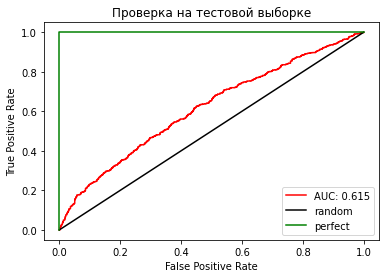

[0 0 0 ... 0 1 0]
[1 0 0 ... 0 0 1]
tn: 1203 fp: 216 fn: 1112 tp: 464
              precision    recall  f1-score   support

           0       0.52      0.85      0.64      1419
           1       0.68      0.29      0.41      1576

    accuracy                           0.56      2995
   macro avg       0.60      0.57      0.53      2995
weighted avg       0.61      0.56      0.52      2995


Positive 1667 Negative 1328 Accuracy 55.66%



In [142]:
#model = load_model('/content/drive/MyDrive/Colab Notebooks/Dipl/Models/Trading_NET_v3_21-04-01-21-28_14.h5')
#Прогнозируем данные текущей сетью
price_scaler_filename = "/content/drive/MyDrive/Colab Notebooks/Dipl/scalers/price_scaler.save"
price_scaler = joblib.load(price_scaler_filename) 

pred = model.predict(xVal)

roc_auc = roc_auc_score(yVal, pred)
fpr, tpr, thresholds = roc_curve(yVal, pred)
print()
plt.plot(fpr, tpr,'r-',label = 'AUC: %.3f'%roc_auc)
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect',)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Проверка на тестовой выборке')
plt.show()

pred = np.array([(1 if i>0.6 else 0) for i in pred])
real = np.array([(1 if i>0.5 else 0) for i in yVal])
print(pred)
print(real)

tn, fp, fn, tp = confusion_matrix(real, pred).ravel()
print('tn:', tn, 'fp:', fp, 'fn:', fn, 'tp:', tp)

print(classification_report(real, pred))

cnt_pos=0
cnt_neg=0
for i in range(real.shape[0]):
  #print('Predict', pred[i], 'Real',real[i])
  if pred[i] == real[i]:
    cnt_pos +=1
  else:
    cnt_neg+=1

print()
print('Positive', cnt_pos, 'Negative',cnt_neg, 'Accuracy {:.2%}'.format(cnt_pos/(cnt_pos+cnt_neg)))
print()